## PyTorch Complete Project Workflow in Amazon SageMaker
### Data Preprocessing -> Code Prototyping -> Automatic Model Tuning -> Deployment
    
1. [Introduction](#Introduction)
2. [SageMaker Processing for dataset transformation](#SageMakerProcessing)
3. [Local Mode training](#LocalModeTraining)
4. [Local Mode endpoint](#LocalModeEndpoint)
5. [SageMaker hosted training](#SageMakerHostedTraining)
6. [Automatic Model Tuning](#AutomaticModelTuning)
7. [SageMaker hosted endpoint](#SageMakerHostedEndpoint)
8. [Workflow Automation with the Step Functions Data Science SDK](#WorkflowAutomation)
    1. [Add an IAM policy to your SageMaker role](#IAMPolicy)
    2. [Create an execution role for Step Functions](#CreateExecutionRole)
    3. [Set up a TrainingPipeline](#TrainingPipeline)
    4. [Visualizing the workflow](#VisualizingWorkflow)
    5. [Creating and executing the pipeline](#CreatingExecutingPipeline)
    6. [Cleanup](#Cleanup)
9. [Extensions](#Extensions)

![images/sagemaker-workflow.png](images/sagemaker-workflow.png)

    
## Introduction <a class="anchor" id="Introduction">

If you are using PyTorch, you can use the Amazon SageMaker prebuilt PyTorch container with training scripts similar to those you would use outside SageMaker. This feature is named Script Mode.  Using Script Mode and other SageMaker features, you can build a complete workflow for a PyTorch project.  This notebook presents such a workflow, including all key steps such as preprocessing data with SageMaker Processing, code prototyping with SageMaker Local Mode training and inference, and production-ready model training and deployment with SageMaker hosted training and inference. Automatic Model Tuning in SageMaker is used to tune the model's hyperparameters.  Additionally, the [AWS Step Functions Data Science SDK](https://aws-step-functions-data-science-sdk.readthedocs.io/en/latest/readmelink.html) is used to automate the main training and deployment steps for use in a production workflow outside notebooks.    

To enable you to run this notebook within a reasonable time (typically less than an hour), this notebook's use case is a straightforward regression task:  predicting house prices based on the well-known Boston Housing dataset. This public dataset contains 13 features regarding housing stock of towns in the Boston area.  Features include average number of rooms, accessibility to radial highways, adjacency to the Charles River, etc.  

To begin, we'll import some necessary packages and set up directories for local training and test data.  We'll also set up a SageMaker Session to perform various operations, and specify an Amazon S3 bucket to hold input data and output.  The default bucket used here is created by SageMaker if it doesn't already exist, and named in accordance with the AWS account ID and AWS Region.
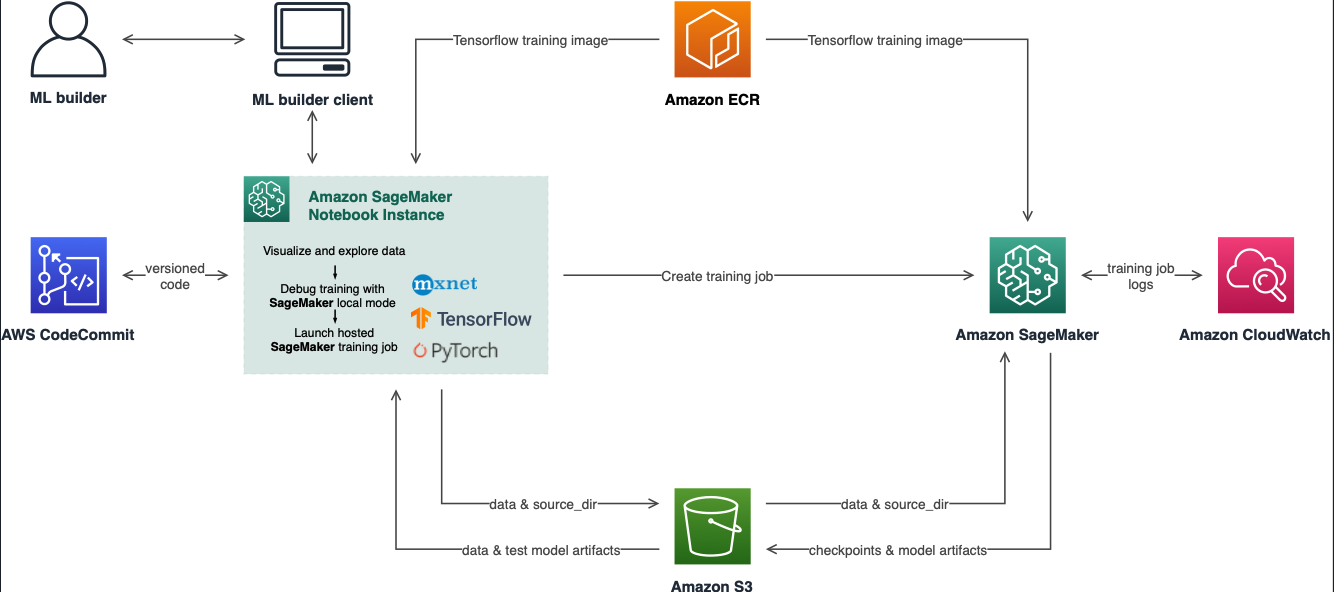

In [ ]:
import os
import sagemaker

sess = sagemaker.Session()
bucket = sess.default_bucket() 

data_dir = os.path.join(os.getcwd(), 'data')
os.makedirs(data_dir, exist_ok=True)

train_dir = os.path.join(os.getcwd(), 'data/train')
os.makedirs(train_dir, exist_ok=True)

test_dir = os.path.join(os.getcwd(), 'data/test')
os.makedirs(test_dir, exist_ok=True)

raw_dir = os.path.join(os.getcwd(), 'data/raw')
os.makedirs(raw_dir, exist_ok=True)

# SageMaker Processing for dataset transformation <a class="anchor" id="SageMakerProcessing">

Next, we'll import the dataset and transform it with SageMaker Processing, which can be used to process terabytes of data in a SageMaker-managed cluster separate from the instance running your notebook server. In a typical SageMaker workflow, notebooks are only used for prototyping and can be run on relatively inexpensive and less powerful instances, while processing, training and model hosting tasks are run on separate, more powerful SageMaker-managed instances.  SageMaker Processing includes off-the-shelf support for Scikit-learn, as well as a Bring Your Own Container option, so it can be used with many different data transformation technologies and tasks.    

First we'll load the Boston Housing dataset, save the raw feature data and upload it to Amazon S3 for transformation by SageMaker Processing.  We'll also save the labels for training and testing.

In [ ]:
from sklearn.datasets import load_boston

In [ ]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

data = load_boston()
X, y = data['data'], data['target']
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
 

np.save(os.path.join(raw_dir, 'x_train.npy'), x_train)
np.save(os.path.join(raw_dir, 'x_test.npy'), x_test)
np.save(os.path.join(train_dir, 'y_train.npy'), y_train)
np.save(os.path.join(test_dir, 'y_test.npy'), y_test)
s3_prefix = 'pytorch-workflow'
rawdata_s3_prefix = '{}/data/raw'.format(s3_prefix)
raw_s3 = sess.upload_data(path='./data/raw/', key_prefix=rawdata_s3_prefix)
print(raw_s3)

To use SageMaker Processing, simply supply a Python data preprocessing script as shown below.  For this example, we're using a SageMaker prebuilt Scikit-learn container, which includes many common functions for processing data.  There are few limitations on what kinds of code and operations you can run, and only a minimal contract:  input and output data must be placed in specified directories.  If this is done, SageMaker Processing automatically loads the input data from S3 and uploads transformed data back to S3 when the job is complete.

In [ ]:
%%writefile preprocessing.py

import glob
import numpy as np
import os
from sklearn.preprocessing import StandardScaler

if __name__=='__main__':
    
    input_files = glob.glob('{}/*.npy'.format('/opt/ml/processing/input'))
    print('\nINPUT FILE LIST: \n{}\n'.format(input_files))
    scaler = StandardScaler()
    for file in input_files:
        raw = np.load(file)
        transformed = scaler.fit_transform(raw)
        if 'train' in file:
            output_path = os.path.join('/opt/ml/processing/train', 'x_train.npy')
            np.save(output_path, transformed)
            print('SAVED TRANSFORMED TRAINING DATA FILE\n')
        else:
            output_path = os.path.join('/opt/ml/processing/test', 'x_test.npy')
            np.save(output_path, transformed)
            print('SAVED TRANSFORMED TEST DATA FILE\n')

Before starting the SageMaker Processing job, we instantiate a `SKLearnProcessor` object.  This object allows you to specify the instance type to use in the job, as well as how many instances.  Although the Boston Housing dataset is quite small, we'll use two instances to showcase how easy it is to spin up a cluster for SageMaker Processing.  

In [ ]:
from sagemaker import get_execution_role
from sagemaker.sklearn.processing import SKLearnProcessor

sklearn_processor = SKLearnProcessor(framework_version='0.20.0',
                                     role=get_execution_role(),
                                     instance_type='ml.m5.xlarge',
                                     instance_count=2)

We're now ready to run the Processing job.  To enable distributing the data files equally among the instances, we specify the `ShardedByS3Key` distribution type in the `ProcessingInput` object.  This ensures that if we have `n` instances, each instance will receive `1/n` files from the specified S3 bucket.  It may take around 3 minutes for the following code cell to run, mainly to set up the cluster.  At the end of the job, the cluster automatically will be torn down by SageMaker.  

In [ ]:
from sagemaker.processing import ProcessingInput, ProcessingOutput
from time import gmtime, strftime 

processing_job_name = "pytorch-workflow-{}".format(strftime("%d-%H-%M-%S", gmtime()))
output_destination = 's3://{}/{}/data'.format(bucket, s3_prefix)

sklearn_processor.run(code='preprocessing.py',
                      job_name=processing_job_name,
                      inputs=[ProcessingInput(
                        source=raw_s3,
                        destination='/opt/ml/processing/input',
                        s3_data_distribution_type='ShardedByS3Key')],
                      outputs=[ProcessingOutput(output_name='train',
                                                destination='{}/train'.format(output_destination),
                                                source='/opt/ml/processing/train'),
                               ProcessingOutput(output_name='test',
                                                destination='{}/test'.format(output_destination),
                                                source='/opt/ml/processing/test')])

preprocessing_job_description = sklearn_processor.jobs[-1].describe()

In the log output of the SageMaker Processing job above, you should be able to see logs in two different colors for the two different instances, and that each instance received different files.  Without the `ShardedByS3Key` distribution type, each instance would have received a copy of **all** files.  By spreading the data equally among `n` instances, you should receive a speedup by approximately a factor of `n` for most stateless data transformations.  After saving the job results locally, we'll move on to prototyping training and inference code with Local Mode.

In [ ]:
train_in_s3 = '{}/train/x_train.npy'.format(output_destination)
test_in_s3 = '{}/test/x_test.npy'.format(output_destination)
!aws s3 cp {train_in_s3} ./data/train/x_train.npy
!aws s3 cp {test_in_s3} ./data/test/x_test.npy

##  Local Mode training <a class="anchor" id="LocalModeTraining">

Local Mode in Amazon SageMaker is a convenient way to make sure your code is working locally as expected before moving on to full scale, hosted training in a separate, more powerful SageMaker-managed cluster. To train in Local Mode, it is necessary to have docker-compose or nvidia-docker-compose (for GPU instances) installed. Running the following commands will install docker-compose or nvidia-docker-compose, and configure the notebook environment for you.

In [ ]:
!wget -q https://raw.githubusercontent.com/aws-samples/amazon-sagemaker-script-mode/master/local_mode_setup.sh
!wget -q https://raw.githubusercontent.com/aws-samples/amazon-sagemaker-script-mode/master/daemon.json    
!/bin/bash ./local_mode_setup.sh

Next, we'll set up a PyTorch Estimator for Local Mode training. Key parameters for the Estimator include:

- `train_instance_type`: the kind of hardware on which training will run. In the case of Local Mode, we simply set this parameter to `local` to invoke Local Mode training on the CPU, or to `local_gpu` if the instance has a GPU. 
- `git_config`:  to make sure training scripts are source controlled for coordinated, shared use by a team, the Estimator can pull in the code from a Git repository rather than local directories.  
- Other parameters of note: the algorithm’s hyperparameters, which are passed in as a dictionary, and a Boolean parameter indicating that we are using Script Mode. 

Recall that we are using Local Mode here mainly to make sure our code is working. Accordingly, instead of performing a full cycle of training with many epochs (passes over the full dataset), we'll train only for a small number of epochs just to confirm the code is working properly and avoid wasting full-scale training time unnecessarily.

In [ ]:
model_dir = '/opt/ml/model'
train_instance_type = 'local'
hyperparameters = {'epochs': 5, 'batch_size': 128, 'learning_rate': 0.01}
local_estimator = sagemaker.PyTorch(
     entry_point='train.py',
     source_dir='model/',
     train_instance_type=train_instance_type,
     train_instance_count=1,
     hyperparameters=hyperparameters,
     role=sagemaker.get_execution_role(),
     base_job_name='pytorch-workflow',
     framework_version='1.5.0',
     py_version='py3'
)

The `fit` method call below starts the Local Mode training job.  Metrics for training will be logged below the code, inside the notebook cell.  You should observe the validation loss decrease substantially over the five epochs, with no training errors, which is a good indication that our training code is working as expected.

In [ ]:
inputs = {'train': f'file://{train_dir}',
          'test': f'file://{test_dir}'}

local_estimator.fit(inputs)

## Local Mode endpoint <a class="anchor" id="LocalModeEndpoint">

While Amazon SageMaker’s Local Mode training is very useful to make sure your training code is working before moving on to full scale training, it also would be useful to have a convenient way to test your model locally before incurring the time and expense of deploying it to production. One possibility is to fetch the PyTorch model artifact or a model checkpoint saved in Amazon S3, and load it in your notebook for testing. However, an even easier way to do this is to use the SageMaker Python SDK to do this work for you by setting up a Local Mode endpoint.

More specifically, the Estimator object from the Local Mode training job can be used to deploy a model locally. With one exception, this code is the same as the code you would use to deploy to production. In particular, all you need to do is invoke the local Estimator's deploy method, and similarly to Local Mode training, specify the instance type as either `local_gpu` or `local` depending on whether your notebook is on a GPU instance or CPU instance.  

Just in case there are other inference containers running in Local Mode, we'll stop them to avoid conflict before deploying our new model locally.

In [ ]:
!docker container stop $(docker container ls -aq) >/dev/null

The following single line of code deploys the model locally in the PyTorch Model Server container:  

In [ ]:
local_predictor = local_estimator.deploy(initial_instance_count=1, instance_type='local')

To get predictions from the Local Mode endpoint, simply invoke the Predictor's predict method.

In [ ]:
local_results = local_predictor.predict(x_test[:10])['predictions']

As a sanity check, the predictions can be compared against the actual target values.

In [ ]:
local_preds_flat_list = [float('%.1f'%(item)) for sublist in local_results for item in sublist]
print('predictions: \t{}'.format(np.array(local_preds_flat_list)))
print('target values: \t{}'.format(y_test[:10].round(decimals=1)))

We only trained the model for a few epochs and there is much room for improvement, but the predictions so far should at least appear reasonably within the ballpark.  

To avoid having the PyTorch inference container indefinitely running locally, simply gracefully shut it down by calling the `delete_endpoint` method of the Predictor object.

In [ ]:
local_predictor.delete_endpoint()

##  SageMaker hosted training <a class="anchor" id="SageMakerHostedTraining">
    
![images/sagemaker-architecture-training.png](images/sagemaker-architecture-training.png)

Now that we've confirmed our code is working locally, we can move on to use SageMaker's hosted training functionality. Hosted training is preferred for doing actual training, especially large-scale, distributed training.  Unlike Local Mode training, for hosted training the actual training itself occurs not on the notebook instance, but on a separate cluster of machines managed by SageMaker.  Before starting hosted training, the data must be in S3, or an EFS or FSx for Lustre file system. We'll upload to S3 now, and confirm the upload was successful.

In [ ]:
s3_prefix = 'pytorch-workflow'

traindata_s3_prefix = '{}/data/train'.format(s3_prefix)
testdata_s3_prefix = '{}/data/test'.format(s3_prefix)

In [ ]:
train_s3 = sess.upload_data(path='./data/train/', key_prefix=traindata_s3_prefix)
test_s3 = sess.upload_data(path='./data/test/', key_prefix=testdata_s3_prefix)

inputs = {'train':train_s3, 'test': test_s3}

print(inputs)

We're now ready to set up an Estimator object for hosted training. It is similar to the Local Mode Estimator, except the `train_instance_type` has been set to a SageMaker ML instance type instead of `local` for Local Mode. Also, since we know our code is working now, we'll train for a larger number of epochs with the expectation that model training will converge to an improved, lower validation loss.

With these two changes, we simply call `fit` to start the actual hosted training.

In [ ]:
from sagemaker.pytorch import PyTorch
import sagemaker

train_instance_type = 'ml.c5.xlarge'
hyperparameters = {'epochs': 30, 'batch_size': 128, 'learning_rate': 0.01}

estimator = PyTorch(
    # Script info
    entry_point='train.py',
    source_dir='model/',
    framework_version='1.6.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    # Instance info
    instance_type=train_instance_type,
    instance_count=1,
    train_use_spot_instances=True,
    train_max_wait=3600,
    train_max_run=3600,
    # Sagemaker-specific info
    role=sagemaker.get_execution_role(),
    base_job_name='pytorch-workflow'
)

After starting the hosted training job with the `fit` method call below, you should observe the training converge over the longer number of epochs to a validation loss that is considerably lower than that which was achieved in the shorter Local Mode training job.  Can we do better? We'll look into a way to do so in the **Automatic Model Tuning** section below. 

In [ ]:
estimator.fit(inputs)

As with the Local Mode training, hosted training produces a model saved in S3 that we can retrieve.  This is an example of the modularity of SageMaker: having trained the model in SageMaker, you can now take the model out of SageMaker and run it anywhere else.  Alternatively, you can deploy the model into a production-ready environment using SageMaker's hosted endpoints functionality, as shown in the **SageMaker hosted endpoint** section below.

Retrieving the model from S3 is very easy:  the hosted training estimator you created above stores a reference to the model's location in S3.  You simply copy the model from S3 using the estimator's `model_data` property and unzip it to inspect the contents.

In [ ]:
!aws s3 cp {estimator.model_data} ./model/model.tar.gz

The unzipped archive should include the assets required by PyTorch inference container to load the model and serve it, including a .pt file:  

In [ ]:
!tar -xvzf ./model/model.tar.gz -C ./model

## Automatic Model Tuning <a class="anchor" id="AutomaticModelTuning">

So far we have simply run one Local Mode training job and one Hosted Training job without any real attempt to tune hyperparameters to produce a better model, other than increasing the number of epochs.  Selecting the right hyperparameter values to train your model can be difficult, and typically is very time consuming if done manually. The right combination of hyperparameters is dependent on your data and algorithm; some algorithms have many different hyperparameters that can be tweaked; some are very sensitive to the hyperparameter values selected; and most have a non-linear relationship between model fit and hyperparameter values.  SageMaker Automatic Model Tuning helps automate the hyperparameter tuning process:  it runs multiple training jobs with different hyperparameter combinations to find the set with the best model performance.

We begin by specifying the hyperparameters we wish to tune, and the range of values over which to tune each one.  We also must specify an objective metric to be optimized:  in this use case, we'd like to minimize the validation loss.

In [ ]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

hyperparameter_ranges = {
  'learning_rate': ContinuousParameter(0.001, 0.2, scaling_type="Logarithmic"),
  'epochs': IntegerParameter(10, 50),
  'batch_size': IntegerParameter(64, 256),
}

metric_definitions = [{'Name': 'MSE',
                       'Regex': ' loss: ([0-9\\.]+)'}]

objective_metric_name = 'MSE'
objective_type = 'Minimize'

Next we specify a HyperparameterTuner object that takes the above definitions as parameters.  Each tuning job must be given a budget:  a maximum number of training jobs.  A tuning job will complete after that many training jobs have been executed.  

We also can specify how much parallelism to employ, in this case five jobs, meaning that the tuning job will complete after three series of five jobs in parallel have completed.  For the default Bayesian Optimization tuning strategy used here, the tuning search is informed by the results of previous groups of training jobs, so we don't run all of the jobs in parallel, but rather divide the jobs into groups of parallel jobs.  There is a trade-off: using more parallel jobs will finish tuning sooner, but likely will sacrifice tuning search accuracy. 

Now we can launch a hyperparameter tuning job by calling the `fit` method of the HyperparameterTuner object.  The tuning job may take around 10 minutes to finish.  While you're waiting, the status of the tuning job, including metadata and results for invidual training jobs within the tuning job, can be checked in the SageMaker console in the **Hyperparameter tuning jobs** panel.  

In [ ]:
tuner = HyperparameterTuner(estimator,
                            objective_metric_name,
                            hyperparameter_ranges,
                            metric_definitions,
                            max_jobs=6,
                            max_parallel_jobs=2,
                            objective_type=objective_type)

tuning_job_name = "pytorch-workflow-{}".format(strftime("%d-%H-%M-%S", gmtime()))
tuner.fit(inputs, job_name=tuning_job_name)
tuner.wait()

After the tuning job is finished, we can use the `HyperparameterTuningJobAnalytics` object from the SageMaker Python SDK to list the top 5 tuning jobs with the best performance. Although the results vary from tuning job to tuning job, the best validation loss from the tuning job (under the FinalObjectiveValue column) likely will be substantially lower than the validation loss from the hosted training job above, where we did not perform any tuning other than manually increasing the number of epochs once.  

In [ ]:
tuner_metrics = sagemaker.HyperparameterTuningJobAnalytics(tuning_job_name)
tuner_metrics.dataframe().sort_values(['FinalObjectiveValue'], ascending=True).head(5)

The total training time and training jobs status can be checked with the following lines of code. Because automatic early stopping is by default off, all the training jobs should be completed normally.  For an example of a more in-depth analysis of a tuning job, see the SageMaker official sample [HPO_Analyze_TuningJob_Results.ipynb](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/hyperparameter_tuning/analyze_results/HPO_Analyze_TuningJob_Results.ipynb) notebook.

In [ ]:
total_time = tuner_metrics.dataframe()['TrainingElapsedTimeSeconds'].sum() / 3600
print("The total training time is {:.2f} hours".format(total_time))
tuner_metrics.dataframe()['TrainingJobStatus'].value_counts()

##  SageMaker hosted endpoint <a class="anchor" id="SageMakerHostedEndpoint">
    
![images/sagemaker-inference-architecture.png](images/sagemaker-inference-architecture.png)

Assuming the best model from the tuning job is better than the model produced by the individual Hosted Training job above, we could now easily deploy that model to production.  A convenient option is to use a SageMaker hosted endpoint, which serves real time predictions from the trained model (Batch Transform jobs also are available for asynchronous, offline predictions on large datasets). The endpoint will retrieve the PyTorch model created during training and deploy it within a SageMaker PyTorch Inference container. This all can be accomplished with one line of code.  

More specifically, by calling the `deploy` method of the HyperparameterTuner object we instantiated above, we can directly deploy the best model from the tuning job to a SageMaker hosted endpoint.  It will take several minutes longer to deploy the model to the hosted endpoint compared to the Local Mode endpoint, which is more useful for fast prototyping of inference code.  

In [ ]:
# If you didn't run the HPO job:
tuning_predictor = estimator.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')
# Otherwise, comment the line above, and uncomment the one below:
# tuning_predictor = tuner.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')

We can compare the predictions generated by this endpoint with those generated locally by the Local Mode endpoint: 

In [ ]:
results = tuning_predictor.predict(x_test[:10])['predictions'] 
flat_list = [float('%.1f'%(item)) for sublist in results for item in sublist]
print('predictions: \t{}'.format(np.array(flat_list)))
print('target values: \t{}'.format(y_test[:10].round(decimals=1)))

To avoid billing charges from stray resources, you can delete the prediction endpoint to release its associated instance(s).

In [ ]:
sess.delete_endpoint(tuning_predictor.endpoint)

## Workflow Automation with the AWS Step Functions Data Science SDK <a class="anchor" id="WorkflowAutomation">

In the previous parts of this notebook, we prototyped various steps of a PyTorch project within the notebook itself.  Notebooks are great for prototyping, but generally are  not used in production-ready machine learning pipelines.  For example, a simple pipeline in SageMaker includes the following steps:  

1. Training the model.
2. Creating a SageMaker Model object that wraps the model artifact for serving.
3. Creating a SageMaker Endpoint Configuration specifying how the model should be served (e.g. hardware type and amount).
4. Deploying the trained model to the configured SageMaker Endpoint.  

The AWS Step Functions Data Science SDK automates the process of creating and running these kinds of workflows using AWS Step Functions and SageMaker.  It does this by allowing you to create workflows using short, simple Python scripts that define workflow steps and chain them together.  Under the hood, all the workflow steps are coordinated by AWS Step Functions without any need for you to manage the underlying infrastructure.  

To begin, install the Step Functions Data Science SDK:  

In [ ]:
import sys

!{sys.executable} -m pip install --quiet --upgrade stepfunctions==1.1.0

### Add an IAM policy to your SageMaker role <a class="anchor" id="IAMPolicy">

**If you are running this notebook on an Amazon SageMaker notebook instance**, the IAM role assumed by your notebook instance needs permission to create and run workflows in AWS Step Functions. To provide this permission to the role, do the following.

1. Open the Amazon [SageMaker console](https://console.aws.amazon.com/sagemaker/). 
2. Select **Notebook instances** and choose the name of your notebook instance
3. Under **Permissions and encryption** select the role ARN to view the role on the IAM console
4. Choose **Attach policies** and search for `AWSStepFunctionsFullAccess`.
5. Select the check box next to `AWSStepFunctionsFullAccess` and choose **Attach policy**

If you are running this notebook in a local environment, the SDK will use your configured AWS CLI configuration. For more information, see [Configuring the AWS CLI](https://docs.aws.amazon.com/cli/latest/userguide/cli-chap-configure.html).


### Create an execution role for Step Functions <a class="anchor" id="CreateExecutionRole">

You also need to create an execution role for Step Functions to enable that service to access SageMaker and other service functionality.

1. Go to the [IAM console](https://console.aws.amazon.com/iam/)
2. Select **Roles** and then **Create role**.
3. Under **Choose the service that will use this role** select **Step Functions**
4. Choose **Next** until you can enter a **Role name**
5. Enter a name such as `StepFunctionsWorkflowExecutionRole` and then select **Create role**


Select your newly create role and attach a policy to it. The following steps attach a policy that provides full access to Step Functions, however as a good practice you should only provide access to the resources you need.  

1. Under the **Permissions** tab, click **Add inline policy**
2. Enter the following in the **JSON** tab

```json
{
    "Version": "2012-10-17",
    "Statement": [
        {
            "Effect": "Allow",
            "Action": [
                "sagemaker:CreateTransformJob",
                "sagemaker:DescribeTransformJob",
                "sagemaker:StopTransformJob",
                "sagemaker:CreateTrainingJob",
                "sagemaker:DescribeTrainingJob",
                "sagemaker:StopTrainingJob",
                "sagemaker:CreateHyperParameterTuningJob",
                "sagemaker:DescribeHyperParameterTuningJob",
                "sagemaker:StopHyperParameterTuningJob",
                "sagemaker:CreateModel",
                "sagemaker:CreateEndpointConfig",
                "sagemaker:CreateEndpoint",
                "sagemaker:DeleteEndpointConfig",
                "sagemaker:DeleteEndpoint",
                "sagemaker:UpdateEndpoint",
                "sagemaker:ListTags",
                "lambda:InvokeFunction",
                "sqs:SendMessage",
                "sns:Publish",
                "ecs:RunTask",
                "ecs:StopTask",
                "ecs:DescribeTasks",
                "dynamodb:GetItem",
                "dynamodb:PutItem",
                "dynamodb:UpdateItem",
                "dynamodb:DeleteItem",
                "batch:SubmitJob",
                "batch:DescribeJobs",
                "batch:TerminateJob",
                "glue:StartJobRun",
                "glue:GetJobRun",
                "glue:GetJobRuns",
                "glue:BatchStopJobRun"
            ],
            "Resource": "*"
        },
        {
            "Effect": "Allow",
            "Action": [
                "iam:PassRole"
            ],
            "Resource": "*",
            "Condition": {
                "StringEquals": {
                    "iam:PassedToService": "sagemaker.amazonaws.com"
                }
            }
        },
        {
            "Effect": "Allow",
            "Action": [
                "events:PutTargets",
                "events:PutRule",
                "events:DescribeRule"
            ],
            "Resource": [
                "arn:aws:events:*:*:rule/StepFunctionsGetEventsForSageMakerTrainingJobsRule",
                "arn:aws:events:*:*:rule/StepFunctionsGetEventsForSageMakerTransformJobsRule",
                "arn:aws:events:*:*:rule/StepFunctionsGetEventsForSageMakerTuningJobsRule",
                "arn:aws:events:*:*:rule/StepFunctionsGetEventsForECSTaskRule",
                "arn:aws:events:*:*:rule/StepFunctionsGetEventsForBatchJobsRule"
            ]
        }
    ]
}
```

3. Choose **Review policy** and give the policy a name such as `StepFunctionsWorkflowExecutionPolicy`
4. Choose **Create policy**. You will be redirected to the details page for the role.
5. Copy the **Role ARN** at the top of the **Summary**

### Set up a TrainingPipeline <a class="anchor" id="TrainingPipeline">

Although the AWS Step Functions Data Science SDK provides various primitives to build up pipelines from scratch, it also provides prebuilt templates for common workflows, including a [TrainingPipeline](https://aws-step-functions-data-science-sdk.readthedocs.io/en/latest/pipelines.html#stepfunctions.template.pipeline.train.TrainingPipeline) object to simplify creation of a basic pipeline that includes model training and deployment. 

The following code cell configures a  `pipeline` object with the necessary parameters to define such a simple pipeline:

In [ ]:
import stepfunctions

from stepfunctions.template.pipeline import TrainingPipeline

# paste the StepFunctionsWorkflowExecutionRole ARN from above
workflow_execution_role = "<execution-role-arn>"

pipeline = TrainingPipeline(
    estimator=estimator,
    role=workflow_execution_role,
    inputs=inputs,
    s3_bucket=bucket
)

### Visualizing the workflow <a class="anchor" id="VisualizingWorkflow">

You can now view the workflow definition, and visualize it as a graph. This workflow and graph represent your training pipeline from starting a training job to deploying the model.

In [ ]:
print(pipeline.workflow.definition.to_json(pretty=True))

In [ ]:
pipeline.render_graph()

### Creating and executing the pipeline <a class="anchor" id="CreatingExecutingPipeline">

Before the workflow can be run for the first time, the pipeline must be created using the `create` method:

In [ ]:
pipeline.create()

Now the workflow can be started by invoking the pipeline's `execute` method:

In [ ]:
execution = pipeline.execute()

Use the `list_executions` method to list all executions for the workflow you created, including the one we just started.  After a pipeline is created, it can be executed as many times as needed, for example on a schedule for retraining on new data.  (For purposes of this notebook just execute the workflow one time to save resources.)  The output will include a list you can click through to access a view of the execution in the AWS Step Functions console.

In [ ]:
pipeline.workflow.list_executions(html=True)

While the workflow is running, you can check workflow progress inside this notebook with the `render_progress` method.  This generates a snapshot of the current state of your workflow as it executes. This is a static image. Run the cell again to check progress while the workflow is running.

In [ ]:
execution.render_progress()

#### BEFORE proceeding with the rest of the notebook:

Wait until the workflow completes with status **Succeeded**, which will take a few minutes.  You can check status with `render_progress` above, or open in a new browser tab the **Inspect in AWS Step Functions** link in the cell output.  

To view the details of the completed workflow execution, from model training through deployment, use the `list_events` method, which lists all events in the workflow execution.

In [ ]:
execution.list_events(reverse_order=True, html=False)

From this list of events, we can extract the name of the endpoint that was set up by the workflow.  

In [ ]:
import re

endpoint_name_suffix = re.search('endpoint\Wtraining\Wpipeline\W([a-zA-Z0-9\W]+?)"', str(execution.list_events())).group(1)
print(endpoint_name_suffix)

Once we have the endpoint name, we can use it to instantiate a PyTorchPredictor object that wraps the endpoint.  This PyTorchPredictor can be used to make predictions, as shown in the following code cell.  

#### BEFORE running the following code cell:

Go to the [SageMaker console](https://console.aws.amazon.com/sagemaker/), click **Endpoints** in the left panel, and make sure that the endpoint status is **InService**.  If the status is **Creating**, wait until it changes, which may take several minutes.

In [ ]:
from sagemaker.pytorch import PyTorchPredictor

workflow_predictor = PyTorchPredictor('training-pipeline-' + endpoint_name_suffix)

results = workflow_predictor.predict(x_test[:10])['predictions'] 
flat_list = [float('%.1f'%(item)) for sublist in results for item in sublist]
print('predictions: \t{}'.format(np.array(flat_list)))
print('target values: \t{}'.format(y_test[:10].round(decimals=1)))

Using the AWS Step Functions Data Science SDK, there are many other workflows you can create to automate your machine learning tasks.  For example, you could create a workflow to automate model retraining on a periodic basis.  Such a workflow could include a test of model quality after training, with subsequent branches for failing (no model deployment) and passing the quality test (model is deployed).  Other possible workflow steps include Automatic Model Tuning, data preprocessing with AWS Glue, and more.  

For a detailed example of a retraining workflow, see the AWS ML Blog post [Automating model retraining and deployment using the AWS Step Functions Data Science SDK for Amazon SageMaker](https://aws.amazon.com/blogs/machine-learning/automating-model-retraining-and-deployment-using-the-aws-step-functions-data-science-sdk-for-amazon-sagemaker/).

### Cleanup <a class="anchor" id="Cleanup">

The workflow we created above deployed a model to an endpoint.  To avoid billing charges for an unused endpoint, you can delete it using the SageMaker console.  To do so, go to the [SageMaker console](https://console.aws.amazon.com/sagemaker/).  Then click **Endpoints** in the left panel, and select and delete any unneeded endpoints in the list.  

## Extensions <a class="anchor" id="Extensions">

We've covered a lot of content in this notebook:  SageMaker Processing for data transformation, Local Mode for prototyping training and inference code, Automatic Model Tuning, and SageMaker hosted training and inference.  These are central elements for most deep learning workflows in SageMaker.  Additionally, we examined how the AWS Step Functions Data Science SDK helps automate deep learning workflows after completion of the prototyping phase of a project.

Besides all of the SageMaker features explored above, there are many other features that may be applicable to your project.  For example, to handle common problems during deep learning model training such as vanishing or exploding gradients, **SageMaker Debugger** is useful.  To manage common problems such as data drift after a model is in production, **SageMaker Model Monitor** can be applied.
    
![images/sagemaker-overview.png](images/sagemaker-overview.png)